# 目的
勾配を用いない最適化法であるCMA-ESを利用している応用側の研究者から，「CMA-ESを用いてみたが，望ましい解が得られない」といった相談やコメントをしばしばいただきます．ここでは，CMA-ESをうまく活用するための設定，実験結果から問題の性質についての分析，問題定式化の検討の観点から，私の経験則をまとめます．

# 参考資料
この資料は，著者らが毎年国際会議GECCOにおいて開催しているCMA-ESチュートリアルを参考にしています．

Youhei Akimoto and Nikolaus Hansen. 2022. CMA-ES and advanced adaptation mechanisms. In Proceedings of the Genetic and Evolutionary Computation Conference Companion (GECCO '22). Association for Computing Machinery, New York, NY, USA, 1243–1268. https://doi.org/10.1145/3520304.3533648
チュートリアル動画：https://www.youtube.com/watch?v=7VBKLH3oDuw






# プログラム
このチュートリアルでは，著者らが公開している最新のCMA-ESの実装である，DD-CMA-ESを用いています．

Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
コード：https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518

In [ ]:
# LaTeX コマンド読み込むための準備（可視化用，1min程度）
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
# https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518 のコピー
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]
    Note
    ----
    If you are interested in constrained optimization and/or multi-fidelity optimization,
    check the following repository:
    https://github.com/akimotolab/multi-fidelity
    
    History
    -------
    2022/03/24: Mirroring box constraint handling and periodic variable handling [3] have been implemented.
    2020/06/10: Restart (IPOP mechanism) [2] has been implemented.
    2019/03/23: release
    Reference
    ---------
    [1] Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
    [2] A. Auger and N. Hansen.
    A Restart CMA Evolution Strategy With Increasing Population Size
    IEEE Congress on Evolutionary Computation (2005): 1769-1776.
    [3] Y. Yamaguchi and A. Akimoto.
    A Note on the CMA-ES for Functions with Periodic Variables
    Genetic and Evolutionary Computation Conference Companion (2018): 227-228.
    """
    
    def __init__(self, xmean0, sigma0, 
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh
        
        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N)) 
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)
        
        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others 
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.
        
        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]
        
        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation        
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy 
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)            

            # force C to be correlation matrix
            cd = np.sqrt(np.diag(self.C))
            self.D *= cd
            self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)            
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)
        
        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx
        
    def upper_bounding_coordinate_std(self, coordinate_length):
        """Upper-bounding coordinate-wise standard deviation
        
        When some design variables are periodic, the coordinate-wise standard deviation 
        should be upper-bounded by r_i / 4, where r_i is the period of the ith variable.
        The correction of the overall covariance matrix, Sigma, is done as follows:
            Sigma = Correction * Sigma * Correction,
        where Correction is a diagonal matrix defined as
            Correction_i = min( r_i / (4 * Sigma_{i,i}^{1/2}), 1 ).
            
        In DD-CMA, the correction matrix is simply multiplied to D.
            
        For example, if a mirroring box constraint handling is used for a box constraint
        [l_i, u_i], the variables become periodic on [l_i - (u_i-l_i)/2, u_i + (u_i-l_i)/2]. 
        Therefore, the period is 
            r_i = 2 * (u_i - l_i).
        
        Parameters
        ----------
        coordinate_length : ndarray (1D) or float
            coordinate-wise search length r_i.
            
        References
        ----------
        T. Yamaguchi and Y. Akimoto. 
        A Note on the CMA-ES for Functions with Periodic Variables.
        GECCO '18 Companion, pages 227--228 (2018)
        """
        correction = np.fmin(coordinate_length / self.coordinate_std / 4.0, 1)
        self.D *= correction
        
        
    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''
    

class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")
                
    def __call__(self, condition=''):
        self.log(condition)
        
    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)  
            for i in key_split:
                var = getattr(var, i)  
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if "e" in float_str:
            base, exponent = float_str.split("e")
            return r"{0}e{1}".format(base, int(exponent))
        else:
            return r"" + float_str + ""
        
    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral'):
        
        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        
        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        mpl.rc('ps', useafm=True)  # Force to use
        mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        mpl.rc('text', usetex=True)  # for a paper submision

        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()
        
        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r'\detokenize{' + key + '}')
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables
            
    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])  
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])     
    return zz

# DD-CMA-ESの概要
ここでは，以下のサンプルスクリプトをを通して，DD-CMA-ESの概要と最適化結果（図）の解釈を説明します．


10 100 6583982533.710756 1143818069.0761855
20 200 274734624.87452656 274734624.87452656
30 300 19281292.794786632 19281292.794786632
40 400 7237734.86179995 4076326.0186667005
50 500 1806853.8297680654 1806853.8297680654
60 600 848076.3791219024 848076.3791219024
70 700 422689.0004410702 236739.8142921987
80 800 199143.10656084336 189171.91809942087
90 900 58294.474498589174 58294.474498589174
100 1000 19634.58277060953 14516.033033640007
110 1100 3718.071573890513 2370.2007320557022
120 1200 320.4688242302509 320.4688242302509
130 1300 178.53164493991062 128.23188549594488
140 1400 109.80310642893892 100.91754627448972
150 1500 94.5642744571669 94.5642744571669
160 1600 92.2456744654337 92.2456744654337
170 1700 91.5981454923749 91.51652749022469
180 1800 91.23744020494632 91.10865080379881
190 1900 89.73647815163713 89.73647815163713
200 2000 86.3144333147211 85.85803348221816
210 2100 73.03526876331307 73.03526876331307
220 2200 48.91065200569574 48.91065200569574
230 2300 8.173801

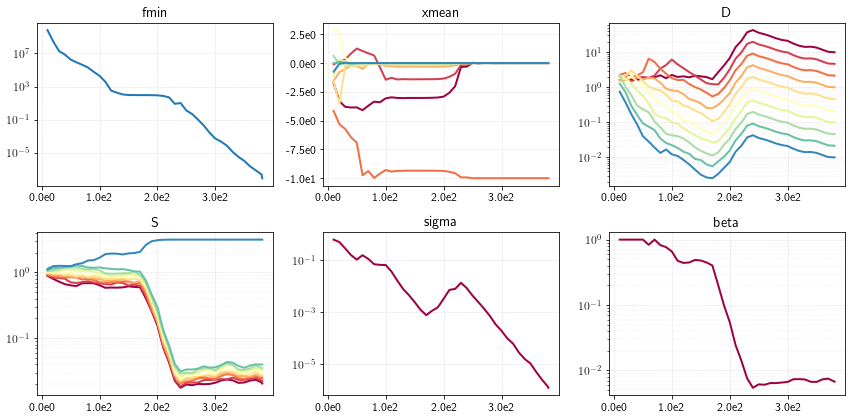

In [3]:
# 実行スクリプト
# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')


## テスト関数の紹介
上のコードを実行した結果得られる最適化結果は，$d = 10$のEllipsoid-Cigar関数と呼ばれる関数
$$f(x) = 10^4 \sum_{i=1}^{d} \left(10^{3\frac{i-1}{d-1}} x_i\right)^2 + \frac{1 - 10^4}{d} \left(\sum_{i=1}^{d} 10^{3\frac{i-1}{d-1}} x_i\right)^2$$
を最適化した結果となります．この関数は凸二次関数ですが，変数毎に目的関数に与える影響が異なる（$10^{3\frac{i-1}{d-1}}$がかかっていることからわかります）ことに加え，$v = (1 / \sqrt{d}, \dots, 1 / \sqrt{d})$方向に対して目的関数が他の方向よりも鈍感である（第二項の影響です）といった特徴を持ちます．なお，この関数のヘッセ行列は
$$\nabla^2 f = 2 D_{\text{ell}} (10^4 I + (1 - 10^4) vv^T) D_{\text{ell}}$$
となります．ここで，$D_{\text{ell}} = \text{diag}(1, \dots, 10^{3\frac{i-1}{d-1}}, \dots, 10^{3})$です．また，その逆行列は
$$(\nabla^2 f)^{-1} = \frac{1}{2} D_{\text{ell}}^{-1} (10^{-4} I + vv^T) D_{\text{ell}}^{-1}$$
となります．



## DD-CMA-ESのアルゴリズムの紹介
DD-CMA-ESでは，多変量正規分布から複数の解を生成し，これらの目的関数を（多くの場合並列に）評価し，解のランキングを用いて多変量正規分布のパラメータを更新していきます．これを繰り返すことで，多変量正規分布を目的関数値の小さな（最小化を想定）領域へと収束させていきます．

DD-CMA-ESでは，多変量正規分布を$\mathcal{N}(m, \sigma^2 D C D)$ と表現します．ここで，$m \in \mathbb{R}^d$ は多変量正規分布の平均ベクトルを表し，プログラムやプロットにおいては xmean と書かれています．図のxmeanでは，$m$の各要素のイテレーション毎の変化がプロットされています．共分散行列は全体のスケーリングを表すステップサイズ $\sigma > 0$，要素毎のスケーリングを表す行列$D$（$d$次元対角行列），要素毎の相関を表す相関行列$C$の３つのパラメータを用いて表現されます．図のsigmaとDは$\sigma$と$D$の各要素を表しています．また，図中のSは相関行列$C$の$d$個の固有値の平方根の推移を表しています．



## 結果の読み取り方

複数の線がある xmean や D のプロットでは，赤系統がインデックスの小さな要素，青系統がインデックスの大きな要素に対応しています．S のプロットでは，固有値の平方根が昇順にソートされているので，カラーと要素のインデックスの間に関係はありません．

まず見るべきは，fmin です．これは，毎イテレーション生成されている解候補の中で，最小の目的関数値を表しています．最終的に望ましい解が得られているならば，実用上はそれ以上に議論する必要はないかもしれません．今回の問題では最適解の目的関数値は0であり，得られている解の目的関数値が指数的に減少している傾向が確認できます．

続いて，sigma を確認します．こちらも指数的に小さくなっていることがわかります．探索終了時点において，$\sigma^{(t)}/\sigma^{(0)} \approx 10^{-6}$程度になっていることから，初期の広がり$\sigma^{(0)}$と比較して十分に小さな分布になっていることがわかります．目的関数値が望ましい値なのかどうか以前に，正しく何らかの点に収束しているのかを見極めるためには，fmin でなく sigma を見ることが重要です．fmin が何らかの値で停滞しているように見える場合，収束しているのか，それとも探索が何らかの理由で進まなくなっているのかを fmin だけから見極めることは困難であるためです．例えば上の結果において，100〜200イテレーションの範囲において，目的関数値が停滞しているように見える箇所があります．目的関数値だけを見ていると，ここまでで収束したと見なしてしまうかもしれませんが，sigmaやSを見ると，共分散行列を適応している最中であることがわかります．

対角行列 D について注目すべきは，要素毎の比です．値が大きいということは，それだけその要素の方向に大きな標準偏差を多変量正規分布が持っていることになります．多変量正規分布がその方向に大きな広がりを持っているということは，目的関数が相対的にその方向への変化に対して鈍感であることを意味します．要素毎の目的関数値に与える感度が D によって学習されている様子が見て取れます．この結果から，この問題はインデックスの小さな変数が目的関数に与える影響は，インデックスの大きな変数が目的関数に与える影響よりも小さく，等高線を描いたとすれば各軸の長さの比が D の要素に比例した形になっているであろうことが予想されます．

最後に相関行列 C の固有値の平方根 S を確認します．イテレーション数が$2 \cdot 10^2$を超えたあたりから，S の最大の要素がその他の要素よりも$10^2$程度大きな値になっていることが見て取れます．これは，要素毎の感度をDが吸収したとしても，要素毎ではない何らかの１方向に対して目的関数に与える影響が鈍感な方向が存在していることがわかります．今回のテスト問題の場合，この方向は $v$ に対応しています．図からは読み取れませんが，以下のコードを実行すると，S の最大値に対応している固有ベクトルを確認することができます．

In [ ]:
ddcma.B[:, -1]  
# B は S の各要素に対応する C の単位固有ベクトル．
# S は昇順にソートされているので，最大値に対応する固有ベクトルは B の最後の列

array([0.31622838, 0.31623837, 0.31620832, 0.31620355, 0.31620815,
       0.31623384, 0.31628735, 0.31622459, 0.31623215, 0.31621295])


経験的には，$D C D$は目的関数のヘッセ行列の逆行列$\nabla^2 f$に比例するような振る舞いが見られます．実際，今回の結果でも，$D$は$D_{\text{ell}}^{-1}$に概ね比例しており，$C$は$10^{-4} I + vv^T$に概ね比例していることが，上の実験結果からも確認されます．

#### まとめ：結果の図から分かること
- 十分に収束しているのか（sigma）
- 目的関数に対する感度が変数毎にどの程度異なるのか（D）
  - 感度が大きく異なる場合（例えばDの最大値と最小値の比が10以上），悪スケールな関数と呼ばれる
  - D の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - D の要素間の比が発散していくような場合，定式化時に注意が必要（後述）
- 変数間の依存関係が強いのか（S）
  - S の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - S の要素間の比が発散していくような場合，定式化時に注意が必要（後述）

# 最適化実行前に検討すべき項目
最適化実行前に検討しておくべきこととしては，以下の３点が挙げられます
1. 目的関数評価回数 & 次元数
2. 初期分布パラメータ
3. ハイパーパラメータ（集団サイズ$\lambda$）
3. リスタート & 終了条件

## 1. 目的関数評価回数 & 次元数（CMA-ESを使うべきか）

まず，アルゴリズムの選択が不適切でないかを考えることが必要です．例えば，以下のような状況の場合には，CMA-ESよりも適切な方法があると考えられます．

- 次元数が高々５次元程度の場合：この場合，経験的にNelder-Mead法などの方が効率的であることが多く見られます．

- 許容できる実行時間内において，目的関数の評価回数が次元数の数十倍に満たない場合：この場合，CMA-ESは収束とみなせる程に分布が小さくなる前に終了してしまい，精度の高い解が得られない可能性が高いです．その場合，次元数が低い場合にはベイズ最適化のような最適化法を採用するか，さもなくばNelder-Mead法やその他の局所探索法を採用したほうが現実的な時間内により望ましい解が得られる可能性が高いように思います．CMA-ESの場合，各イテレーションで生成される解候補は並列に評価することが可能なので，並列評価が可能なのであれば，これを考慮して最大評価回数を計算しましょう．

## 2. 初期分布パラメータ

初期分布のパラメータ $m^{(0)}$，$\sigma^{(0)}$, $D^{(0)}$, $C^{(0)}$ は，目的関数が複数の局所解を有する場合には重要な検討項目となります．ただし，予め変数毎のスケーリングなどを知らない限り$D^{(0)} = I$とし，変数間の依存関係などを知らない限り$C^{(0)} = I$とすることが自然です．以下，$m^{(0)}$と$\sigma^{(0)}$ について議論します．

- 有望な解の候補を知っている場合：例えば，既存の設計などの既存の解 $x_{\text{guess}}$ を持っている場合には，この解の周辺に初期化することが望ましいでしょう．これにより，少なくともこの初期解よりも優れた解の発見が期待できます．例えば，$m^{(0)} = x_{\text{guess}}$とし，$\sigma^{(0)}$を十分に小さな値とすれば，これを実現できます．ここで，$\sigma^{(0)}$は，対象としている問題毎に異なるでしょう．例えば，解の各要素が$10^{-4}$程度変化しただけではほとんど目的関数に影響しないであろう，などといった既存知識があるのであれば，$\sigma^{(0)} = 10^{-4}$などとすれば良いでしょう．変数毎にこの値が変わるようであれば，$\sigma^{(0)} = 1$とし，代わりに$D^{(0)}$の要素を変数毎に上と同様の方法で決定すれば良いでしょう．CMA-ESでは，分布の広がりが小さすぎる場合（すなわち大きく移動すれば目的関数を改善できるのに，広がりが狭すぎで移動できない場合），比較的高速に$\sigma$を大きくすることが可能なので，局所的な探索をしたい場合には，十分に小さな$\sigma^{(0)}$で初期化しておけば良いでしょう．

- 各設計変数の定義域が有限な場合 or 各設計変数の合理的な値の範囲を知っている場合：この場合，各設計変数の範囲$[L, U]$の中で，ランダムに初期化することが望ましいでしょう．例えば，$m^{(0)}_i \sim \mathcal{U}[L_i, U_i]$などと区間内の一様分布に従ってサンプリングし，$\sigma^{(0)} = 1$，$D^{(0)}_i = \frac{U_i - L_i}{4}$ などと初期化する方法が考えられます．ただし，$\sigma^{(0)}$については，より小さな値で初期化したほうがいい場合もあります．$\sigma^{(0)}$が大きいほど，特定の局所解に収束しがちになります．これが望ましい局所解であればよいのですが，そうでない場合，小さな$\sigma^{(0)}$としたほうが，多様な局所解を探索できる場合があります．

実際には，一度しか探索できないという場面は少ないでしょうから，有望な解の候補を知っている場合には，まずはその解を$m^{(0)}$，$\sigma^{(0)}$を適切に定めて探索し，その後$\sigma^{(0)}$を$10$倍して探索，$100$倍して探索，などと，徐々に大域的な探索を実行していくことが良いかと思います．なお，$\sigma^{(0)}$が大きくなるほど，$m^{(0)}$への依存性は下がっていきます．

### 2.1 10次元Rosenbrock 関数での例
Rosenbrock関数は
$$f(x) = \sum_{i=1}^{d-1} 100  \left(x_i^2 - x_{i+1}\right)^2 + \left( x_i - 1 \right)^2$$
と定義される四次関数です．最適解は$x^* = (1, \dots, 1)$となりますが，$(0, \dots, 0)$と$(1, \dots, 1)$をつなぐ曲線の周辺のみが低い目的関数値を取り，それ以外が相対的に高い目的関数値を取るような関数です．広い範囲を探索した場合，どこから探索してもまず原点付近に正規分布が一度集まるような傾向が見られます．

#### 確認事項
- 原点に平均ベクトルを初期化した場合，mode 1 ($\sigma^{(0)} = 10^{-1}$)とmode 2 ($\sigma^{(0)} = 10^{-4}$)を比較することで，初期ステップサイズが小さすぎる場合には高速にこれを大きくできることを確認．
- 最適解周辺に平均ベクトルを初期化した場合，mode 3 ($\sigma^{(0)} = 10^{-1}$)とmode 4 ($\sigma^{(0)} = 1$)を比較することで，初期ステップサイズが十分に小さくないと局所探索にならない（良い解からスタートすることの意味があまりない）ことを確認．

10 100 531.556942738771 407.65689048761385
20 200 195.87463097484553 195.87463097484553
30 300 27.752840041205612 27.752840041205612
40 400 8.34968229021175 8.34968229021175
50 500 5.850959003838015 5.47023126438995
60 600 4.641485302451502 4.641485302451502
70 700 4.43458509359257 4.43458509359257
80 800 4.395665132037955 4.395665132037955
90 900 4.356892201888088 4.356495664187351
100 1000 4.3223539569926865 4.314149136201813
110 1100 4.234444397606038 4.234444397606038
120 1200 4.1628479017361295 4.14117111021105
130 1300 4.0642368423279756 4.06364157577752
140 1400 4.022418671821844 4.022418671821844
150 1500 4.008238123588947 3.997544258521306
160 1600 3.991171550442777 3.991171550442777
170 1700 3.988346982183228 3.9879353188892
180 1800 3.9871289532495116 3.9871289532495116
190 1900 3.986732754663428 3.9866309607913104
200 2000 3.9865929062087515 3.9865929062087515
210 2100 3.9865847812749777 3.9865832492289157
220 2200 3.986580097718081 3.986580097718081
230 2300 3.986579264102

<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


Terminated with condition: bbob_tolhistfun
Restart with popsize: 20
10 200 303.3522475899041 198.91109378162267
20 400 28.02101151912725 28.02101151912725
30 600 8.820378907544438 8.003645393469885
40 800 7.171923398775251 7.171923398775251
50 1000 6.385659633018132 6.367936198063012
60 1200 5.607587159163081 5.607587159163081
70 1400 4.97884879311373 4.97884879311373
80 1600 4.523059338567228 4.523059338567228
90 1800 4.062828623857041 4.062828623857041
100 2000 3.8237375884307845 3.8237375884307845
110 2200 3.5022455003149937 3.442991125277289
120 2400 2.7680683512154625 2.7680683512154625
130 2600 2.172545746706444 2.172545746706444
140 2800 1.852715915040906 1.8124181078032917
150 3000 1.469177463363845 1.469177463363845
160 3200 1.135260873703818 1.0352668472206643
170 3400 0.7913791189291897 0.7879584692195073
180 3600 0.4975097292039117 0.48881564190219945
190 3800 0.30862637197741305 0.30862637197741305
200 4000 0.1833390490125461 0.12892307950981888
210 4200 0.0642180418102042

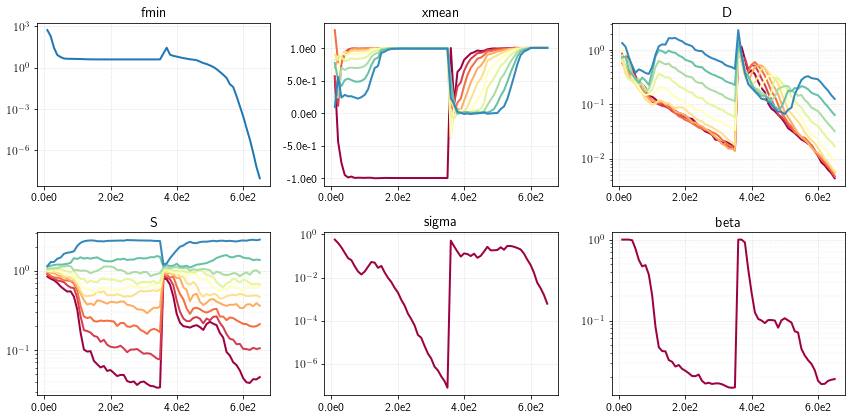

In [28]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rosenbrock(x):
    a = 1e2                
    return a * np.sum(
        (x[:, :-1]**2 - x[:, 1:])**2, axis=1) + np.sum(
            (x[:, :-1] - 1.0)**2, axis=1)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rosenbrock(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 3
if mode == 0:
    # 原点に初期化
    xmean0 = np.zeros(N)
    D0 = 1e-1 * np.ones(N)
elif mode == 1:
    # 原点に初期化（初期ステップサイズがかなり小さい場合）
    xmean0 = np.zeros(N)
    D0 = 1e-4 * np.ones(N)
elif mode == 2:
    # 最適解周りに初期化
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 3:
    # 最適解周りに初期化（初期ステップサイズが大きい場合）
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

### 2.1 10次元Rastrigin 関数での例
Rastrigin関数は
$$f(x) = \sum_{i=1}^{d} x_i^2 + 10 ( 1 - \cos(2 \pi x_i))$$
と定義される多峰性関数（局所解を複数持つ関数）です．最適解は$x^* = (0, \dots, 0)$となりますが，各座標の値が整数の値付近において，局所解が存在します．ただし，巨視的に見ると下凸のような景観をしています．

#### 確認事項
- $m^{(0)}$を$(1, \dots, 1)$付近に初期化した場合，初期ステップサイズが十分に小さければ（ここでは$\sigma^{(0)} = 0.1$），局所的に目的関数値が改善されること．
- ただし，あくまで局所的にしか改善されないため，比較的大きな$\sigma^{(0)}$のほうが良い局所解へと収束する場合があること．当然，悪くなる場合もあること．

10 100 93.18954823432026 52.903753816677636
20 200 80.18606181951415 52.903753816677636
30 300 68.84021198604133 52.71917363909298
40 400 59.016401376433485 42.39069254721602
50 500 31.641545274012877 30.30691548958426
60 600 21.57779727677214 20.83893587056747
70 700 19.442445211664364 19.442445211664364
80 800 18.981337246182587 18.981337246182587
90 900 18.913810402720724 18.913810402720724
100 1000 18.90882603532224 18.907274437929054
110 1100 18.9048115357773 18.9048115357773
120 1200 18.90423448844885 18.90423448844885
130 1300 18.904224176222648 18.904214962086016
140 1400 18.904209483571936 18.904209483571936
150 1500 18.90420767376422 18.90420767376422
160 1600 18.90420703967348 18.90420703967348
170 1700 18.90420698455118 18.904206982066363
180 1800 18.904206973162452 18.904206973151485
190 1900 18.904206971631307 18.904206971487973
200 2000 18.904206971329256 18.904206971329256
210 2100 18.90420697132031 18.904206971319354
220 2200 18.904206971315542 18.904206971315542
230 2

<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


250 2500 18.904206971315308 18.904206971315308
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20


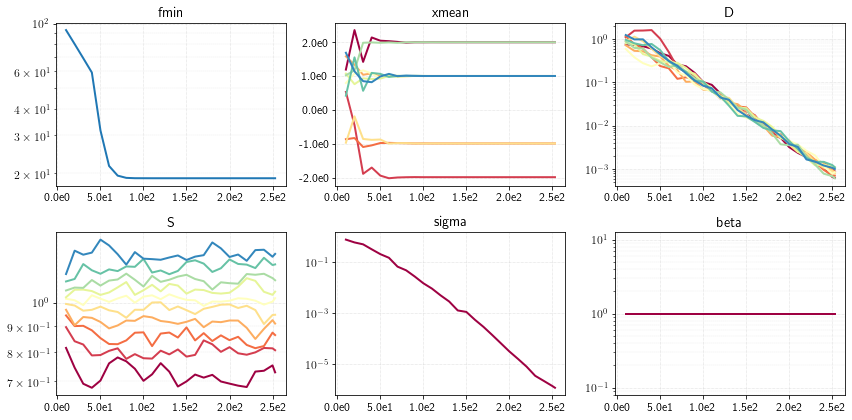

In [32]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 1
if mode == 0:
    # ステップサイズが小さい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 1:
    # ステップサイズが相対的に大きい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1.0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 3. ハイパーパラメータ（集団サイズ$\lambda$）

CMA-ESのハイパーパラメータ全てに対して，最適化問題の次元数から求まる推奨値が設計されています．ただし，集団サイズ$\lambda$については，大きな値を与えることが望ましい場合があります．なお，$\lambda$を大きくすると，自動的に学習率などのパラメータの推奨値も変化します．

1. 目的関数の評価を，デフォルトの$\lambda$ ($= 4 + \lfloor 3 \log(d) \rfloor$)よりも多く並列計算可能である場合．一般に，$\lambda \leq d$ 程度までは，$\lambda$を大きくすれば，探索に必要なイテレーション数は少なくなるため，探索終了までの実時間を削減することが可能です．
2. 目的関数が多峰性関数である場合．集団サイズを大きくすることでより目的関数値の小さな局所解を得られる場合が多くあります．

### 3.1 並列化のために集団サイズを増加させる効果の確認
10次元 Ellipsoid-Cigar 関数を用いて，デフォルトの集団サイズの場合（$\lambda = 10$，一番上の図）と大きな集団サイズ$\lambda = 20, 40, 80, \dots$の場合のイテレーション数を比較します．位置イテレーションに必要な評価を全て並列計算できる場合，実行時間はイテレーション数に概ね依存します．

10 400 54738925.46112473 54738925.46112473
20 800 1797430.8267220396 1797430.8267220396
30 1200 200482.47617817612 200482.47617817612
40 1600 11044.44975755422 7848.560999690613
50 2000 354.5706268529757 354.5706268529757
60 2400 42.77680362894898 42.77680362894898
70 2800 36.05511175002903 36.05511175002903
80 3200 30.2351150495233 30.2351150495233
90 3600 9.021403352296147 9.021403352296147
100 4000 1.8286988456979998 1.4482838854178226
110 4400 0.2604376681632061 0.21496781320856684
120 4800 0.015211704755464961 0.013082854735670169
130 5200 0.0010385570170210467 0.0010385570170210467
140 5600 6.016076491940914e-05 6.016076491940914e-05
150 6000 7.733262416678016e-06 6.539325078072384e-06
160 6400 7.446542340133235e-07 7.446542340133235e-07
170 6800 8.786053717549499e-08 8.577488059169532e-08
Terminated with condition: ftarget


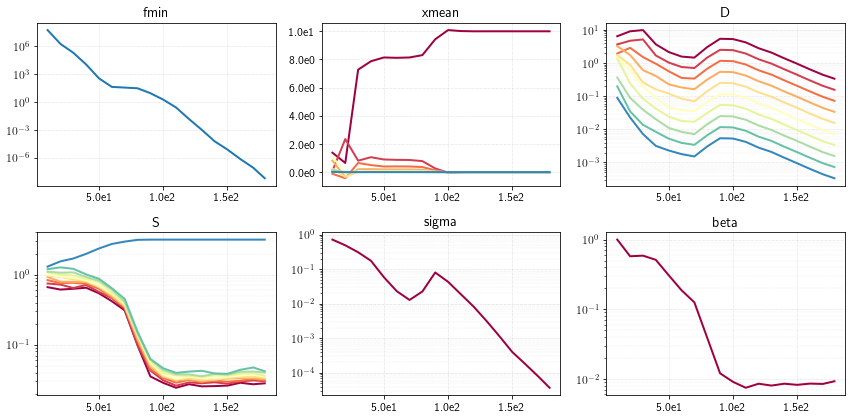

In [25]:
# 実行スクリプト
lam = 10

# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=lam)  # 変更点はここ
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

集団サイズを大きくした場合に必要なイテレーション数が減少するのは，分布パラメータの更新に用いる学習率を大きく設定できる（推奨値もそのように設定されている）ためです．また，学習率の推奨値の設定から，$\lambda = 4d^2$程度まではイテレーション数を削減できますが，それ以上ではイテレーション数は削減されません．

### 3.2 多峰性関数における集団サイズを増加させる効果の確認

上述のRastrigin関数のように，大域的に見れば下凸になっているようにみえる多峰性関数を大域的単峰な関数，もしくは大谷構造をもつ関数，などと呼びます．このような関数の場合，
- 初期ステップサイズを大きめに設定
- 集団サイズを大きめに設定
することで，目的関数値の低い局所解を獲得できる可能性があります．

10 100 76.87097443218863 73.082854690054
20 200 94.70478398428678 73.082854690054
30 300 101.87030059444592 68.61790073207796
40 400 104.43577569561803 68.61790073207796
50 500 111.78822539217508 68.61790073207796
60 600 72.64540361153894 65.37001566264743
70 700 51.03092849201009 39.081206034779825
80 800 36.629418742462654 23.35200165308434
90 900 26.276432642316266 23.35200165308434
100 1000 22.127018770635054 17.33472803688112
110 1100 21.404953346269185 17.33472803688112
120 1200 17.140431515518635 17.140431515518635
130 1300 16.375624293918946 16.030311584670955
140 1400 15.403809079902935 15.403809079902935
150 1500 15.235861132301396 15.135294244517237
160 1600 14.97320609414592 14.97320609414592
170 1700 14.937675115137049 14.937675115137049
180 1800 14.930018299912055 14.928355839007489
190 1900 14.924678419541703 14.924678419541703
200 2000 14.924507604222804 14.924507604222804
210 2100 14.924395644946854 14.92439439521231
220 2200 14.924373252326477 14.924373252326477
230 2

<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


340 3400 14.92437074294214 14.924370742942138
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20


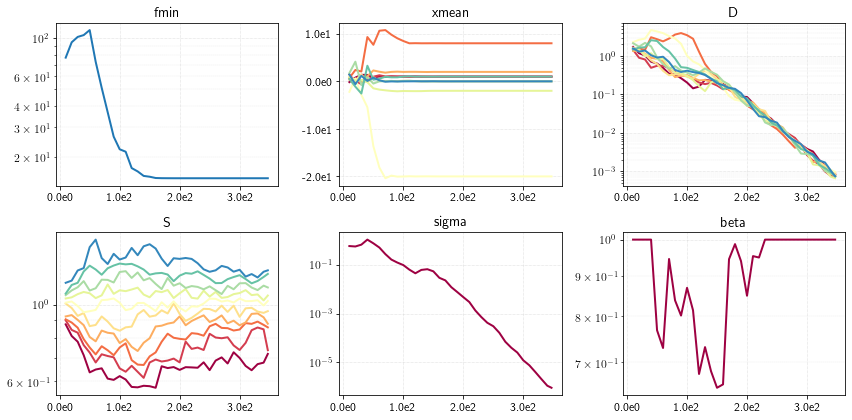

In [49]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
mode = 2
if mode == 0:
    lam = 200
    D0 = 2 * np.ones(N)
elif mode == 1:
    lam = 200
    D0 = 0.1 * np.ones(N)
elif mode == 2:
    lam = 10
    D0 = 2 * np.ones(N)
else:
    lam = 10
    D0 = 0.1 * np.ones(N) 


def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

一方で，例外も存在します．例えば，Double-Sphere関数（$s > 0$）
$$
f(x) = \min\left[ \sum_{i=1}^{d} (x_i - a_i)^2, d + s \sum_{i=1}^{d} (x_i - b_i)^2\right]
$$
がこれに該当します．この関数は二つの局所解しか持ちません．最適解は$a$で目的関数値が$f(a) = 0$，もう一つの局所解が$b$で目的関数値が$f(b) = d$となります．Rastrigin関数と異なり，大域的にみても二つの関数に分かれてしまっていることがわかります．また，$s$が小さい場合，局所解を形成する方の目的関数値のほうが小さい領域が広く存在しています．このような関数の場合，ステップサイズを大きくして大域的な探索を試みると，局所解の谷しか見えず（大域的最適解を形成する関数の領域に解が生成される確率が低い），局所解に収束する現象が見られます．このような関数を大域的多峰な関数であったり，UV構造を持つ関数などといいます．

#### 確認項目
Double Sphere関数の場合
- 初期ステップサイズを大きめに設定
- 集団サイズを大きめに設定
がいずれも逆効果になること

10 2000 10.284693982223176 10.194914323759157
20 4000 10.000189439453015 10.000189439453015
30 6000 10.000000116181454 10.000000116181454
40 8000 10.000000000035957 10.000000000035957


<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


50 10000 10.000000000000016 10.000000000000016
Terminated with condition: bbob_tolhistfun
Restart with popsize: 400


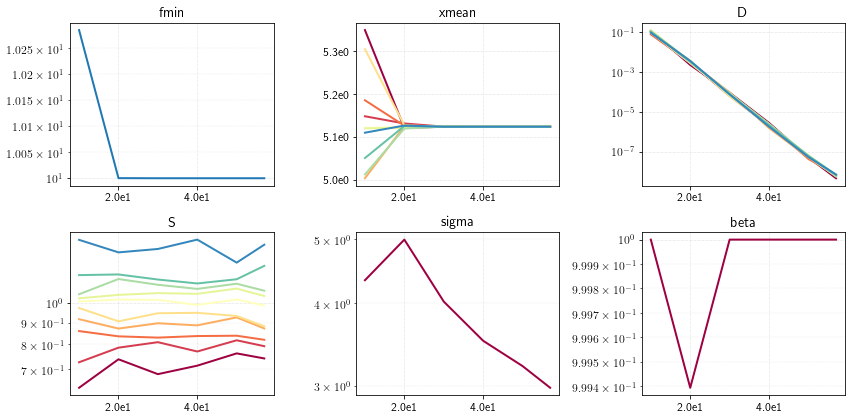

In [60]:
# 実行スクリプト
N = 10
xmean0 = np.zeros(N)
mode = 0
if mode == 0:
    lam = 200
    D0 = 2 * np.ones(N)
elif mode == 1:
    lam = 200
    D0 = 0.1 * np.ones(N)
elif mode == 2:
    lam = 10
    D0 = 2 * np.ones(N)
else:
    lam = 10
    D0 = 0.1 * np.ones(N) 


def doublesphere(x):
    s = 0.2
    a = 2.5
    b = np.sqrt((a**2 - 1) / s)
    f1 = np.sum((x[:, :] - a)**2, axis=1)
    f2 = N + s * np.sum((x[:, :] - b)**2, axis=1)
    return np.fmin(f1, f2)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = - np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return doublesphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 4. リスタート & 終了条件

一度の探索で望ましい解が得られる可能性は現実的にはかなり低いでしょう．その場合，繰り返し探索を行うことが必須となります．その際，前項目で見たように，集団サイズや初期分布パラメータを変えながらリスタートすることが望ましいです．そのようなリスタート戦略は，IPOPメカニズム，BIPOPメカニズムなどとして，提案されています．今回のコードでは，IPOPメカニズム（リスタート毎に集団サイズを倍にする方法）が実装されています．

リスタート戦略を用いる際，利用者が検討すべき項目は，各リスタートの終了条件です．終了条件が適切でないと，探索が終わっていないのに打ち切ってしまう，もしくはいつまでもリスタートがかからない，といった問題があります．

上のコードでは，
- 分布が小さくなったら終了
- 共分散行列の条件数が大きくなりすぎたら終了
- 目的関数値が一定イテレーション以上改善されなければ終了
- ある目的関数値に到達したら終了（この場合，リスタートもかけない）
- 最大の目的関数評価回数に達したら終了（この場合，リスタートもかけない）
などの終了条件が実装されています．分布の大きさや条件数に関する終了条件のしきい値は，計算誤差を考慮して予め設定されていますが，実際に解いている問題によっては，ある程度以上変数が変化しない限りほとんど目的関数に差は無いから無視して良い，もしくはある程度以上の精度で解を社会実装できないから，それ以上の精度はそもそも必要ない，などといった事前情報がある場合があるでしょう．その場合には，しきい値を事前情報によって調整することで，効率的な探索が可能になる可能性があります．

10 100 20.142344840614697 17.721521807451328
20 200 12.6243663572325 12.034027134840418
30 300 10.080348497787988 10.080348497787988
40 400 9.985269781844133 9.977585785506507
50 500 9.955242187799707 9.953353263741123
60 600 9.950240478639016 9.950240478639016
70 700 9.949696276897704 9.949696276897704
80 800 9.9496087945292 9.9496087945292
90 900 9.94959286540889 9.94959286540889
100 1000 9.949590850590125 9.949590850590125
110 1100 9.949590677842323 9.949590630297413
120 1200 9.949590586708057 9.949590585528627
130 1300 9.949590572615135 9.949590572573406
140 1400 9.94959057136757 9.94959057133042
150 1500 9.949590570982867 9.949590570982272
160 1600 9.949590570950159 9.949590570939488
170 1700 9.949590570934099 9.949590570934099
180 1800 9.949590570933362 9.949590570933246
190 1900 9.949590570932935 9.949590570932935


<ipython-input-2-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


200 2000 9.94959057093292 9.949590570932916
210 2100 9.949590570932914 9.949590570932914
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20
10 200 84.2634040075433 79.36067577109084
20 400 85.80828955189871 58.49561989894095
30 600 60.553207800980424 39.96252509559608
40 800 36.512737185990204 36.512737185990204
50 1000 37.42066621758914 36.512737185990204
60 1200 19.476605339883363 18.573515623025596
70 1400 11.290215805104108 11.290215805104108
80 1600 5.860311148176096 5.652469326492445
90 1800 4.344810727480601 4.084433434827933
100 2000 3.1190215467042646 3.1190215467042646
110 2200 3.0097376662743414 2.998534115969466
120 2400 2.9874005238362993 2.986962104896152
130 2600 2.9849702063547054 2.9849702063547054
140 2800 2.984904780600812 2.984904780600812
150 3000 2.984881094004023 2.984881094004023
160 3200 2.9848775275036568 2.9848774740573965
170 3400 2.984877210962279 2.984877210962279
180 3600 2.9848771774360934 2.9848771774360934
190 3800 2.9848771720864535 2

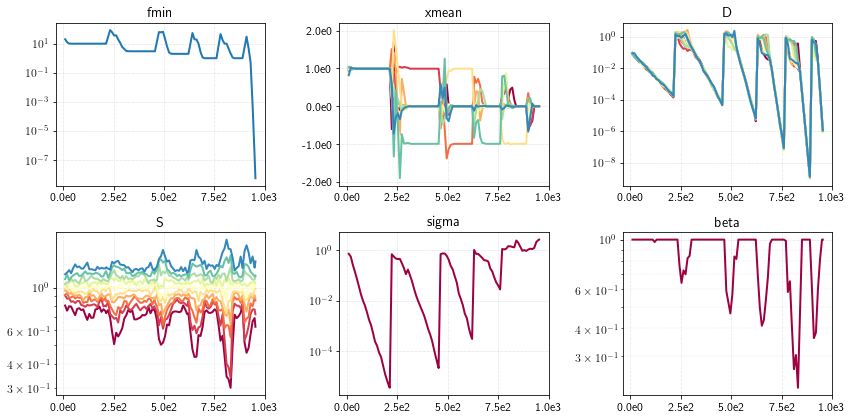

In [62]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
D0 = 0.1 * np.ones(N)

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

# 最適化実行後の定式化の見直し

最適化を実行してみたが望ましい解が得られない，という場面は多々あると思います．まず前項目までにみた検討項目について，十分な回数のリスタートがなされているのか，適切な終了条件が設定されているのか，初期分布パラメータは適切か，など，再度確認してみましょう．それでもうまく行かない場合，最適化問題の定式化を再検討することが必要になります．その際，分布パラメータの推移（上で出力しているような図）も確認しましょう．その中に，うまく解くためのヒントが隠されている場合があります．

ここでは，実際に起こりがちな，CMA-ESにとって解きにくい目的関数の設計と，そのときのCMA-ESの振る舞いをいくつか紹介します．

1. ほとんど平らな多峰性の目的関数 or 周期関数
2. 目的関数に影響を与えない変数
3. 尖った等高線を持つ目的関数

## 1. ほとんど平らな多峰性の目的関数 or 周期関数





## 2. 目的関数に影響を与えない変数

## 3. 尖った等高線を持つ目的関数